In [297]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.initializers import he_normal
import keras.backend as K
from sklearn.metrics import mean_squared_error
from math import sqrt

In [298]:
df = pd.read_csv("train_ML_IOT.csv", parse_dates=[0], infer_datetime_format=True)
df.head()

C:\Users\Stajyer\AppData\Local\Temp\ipykernel_17252\2222497390.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv("train_ML_IOT.csv", parse_dates=[0], infer_datetime_format=True)


,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [299]:
convert_dictionary = {'Junction': float}
df = df.astype(convert_dictionary)
df

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1.0,15,20151101001
1,2015-11-01 01:00:00,1.0,13,20151101011
2,2015-11-01 02:00:00,1.0,10,20151101021
3,2015-11-01 03:00:00,1.0,7,20151101031
4,2015-11-01 04:00:00,1.0,9,20151101041
...,...,...,...,...
48115,2017-06-30 19:00:00,4.0,11,20170630194
48116,2017-06-30 20:00:00,4.0,30,20170630204
48117,2017-06-30 21:00:00,4.0,16,20170630214
48118,2017-06-30 22:00:00,4.0,22,20170630224


In [300]:
X=df.values
y=df.iloc[38496:48120,0:3].values
y

array([[Timestamp('2016-11-23 00:00:00'), 3.0, 17],
       [Timestamp('2016-11-23 01:00:00'), 3.0, 12],
       [Timestamp('2016-11-23 02:00:00'), 3.0, 10],
       ...,
       [Timestamp('2017-06-30 21:00:00'), 4.0, 16],
       [Timestamp('2017-06-30 22:00:00'), 4.0, 22],
       [Timestamp('2017-06-30 23:00:00'), 4.0, 12]], dtype=object)

In [301]:
X.shape, y.shape

((48120, 4), (9624, 3))

In [302]:
train = pd.DataFrame(X, columns = ['DateTime','Junction','Vehicles','ID'])
train

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1.0,15,20151101001
1,2015-11-01 01:00:00,1.0,13,20151101011
2,2015-11-01 02:00:00,1.0,10,20151101021
3,2015-11-01 03:00:00,1.0,7,20151101031
4,2015-11-01 04:00:00,1.0,9,20151101041
...,...,...,...,...
48115,2017-06-30 19:00:00,4.0,11,20170630194
48116,2017-06-30 20:00:00,4.0,30,20170630204
48117,2017-06-30 21:00:00,4.0,16,20170630214
48118,2017-06-30 22:00:00,4.0,22,20170630224


In [303]:
test = pd.DataFrame(y, columns = ['DateTime','Junction','Vehicles'])
test

,DateTime,Junction,Vehicles
0,2016-11-23 00:00:00,3.0,17
1,2016-11-23 01:00:00,3.0,12
2,2016-11-23 02:00:00,3.0,10
3,2016-11-23 03:00:00,3.0,7
4,2016-11-23 04:00:00,3.0,4
...,...,...,...
9619,2017-06-30 19:00:00,4.0,11
9620,2017-06-30 20:00:00,4.0,30
9621,2017-06-30 21:00:00,4.0,16
9622,2017-06-30 22:00:00,4.0,22


In [304]:
train_temp = train.set_index(['Junction','DateTime'])  # set the index
train_temp

Vehicles           ID
Junction DateTime                                 
1.0      2015-11-01 00:00:00       15  20151101001
         2015-11-01 01:00:00       13  20151101011
         2015-11-01 02:00:00       10  20151101021
         2015-11-01 03:00:00        7  20151101031
         2015-11-01 04:00:00        9  20151101041
...                               ...          ...
4.0      2017-06-30 19:00:00       11  20170630194
         2017-06-30 20:00:00       30  20170630204
         2017-06-30 21:00:00       16  20170630214
         2017-06-30 22:00:00       22  20170630224
         2017-06-30 23:00:00       12  20170630234

[48120 rows x 2 columns]

In [305]:
level_values = train_temp.index.get_level_values
level_values

<bound method MultiIndex.get_level_values of MultiIndex([(1.0, '2015-11-01 00:00:00'),
            (1.0, '2015-11-01 01:00:00'),
            (1.0, '2015-11-01 02:00:00'),
            (1.0, '2015-11-01 03:00:00'),
            (1.0, '2015-11-01 04:00:00'),
            (1.0, '2015-11-01 05:00:00'),
            (1.0, '2015-11-01 06:00:00'),
            (1.0, '2015-11-01 07:00:00'),
            (1.0, '2015-11-01 08:00:00'),
            (1.0, '2015-11-01 09:00:00'),
            ...
            (4.0, '2017-06-30 14:00:00'),
            (4.0, '2017-06-30 15:00:00'),
            (4.0, '2017-06-30 16:00:00'),
            (4.0, '2017-06-30 17:00:00'),
            (4.0, '2017-06-30 18:00:00'),
            (4.0, '2017-06-30 19:00:00'),
            (4.0, '2017-06-30 20:00:00'),
            (4.0, '2017-06-30 21:00:00'),
            (4.0, '2017-06-30 22:00:00'),
            (4.0, '2017-06-30 23:00:00')],
           names=['Junction', 'DateTime'], length=48120)>

In [306]:
time_targets = train_temp.groupby([level_values(0)]+[pd.Grouper(freq='1M',level=-1)])['Vehicles'].sum()
time_targets

Junction  DateTime  
1.0       2015-11-30    14736
          2015-12-31    15487
          2016-01-31    17940
          2016-02-29    20813
          2016-03-31    22215
                        ...  
4.0       2017-02-28     5564
          2017-03-31     4931
          2017-04-30     4454
          2017-05-31     4877
          2017-06-30     6097
Name: Vehicles, Length: 66, dtype: object

The first level: The expression level_values(0) refers to the first level (first index) of the DataFrame. This is likely some kind of category or grouping criterion in the DataFrame.

The second level: The [pd.Grouper(freq='1M', level=-1)] expression allows the data to be grouped at the second level on a monthly basis. The pd.Grouper class is used to group data at a specific frequency (in this case, monthly). The level=-1 expression specifies that this operation should be performed at the last level of the DataFrame.

Finally, during the grouping process, the sum() operation is applied to the 'Vehicles' column. This calculates the sum of values in the 'Vehicles' column for each group. In other words, it calculates the total number of vehicles in each month or for each category.

The result is a time series DataFrame that contains grouped and summed data:

The first level (first index) is grouped according to the grouping criterion and on a monthly frequency.
The second level contains the total values from the 'Vehicles' column for each group. This represents the total number of vehicles for each month or category.

In [307]:
df_time_targets = pd.DataFrame(time_targets)
df_time_targets['Junction'] = df_time_targets.index.get_level_values(0)
df_time_targets['Date'] = df_time_targets.index.get_level_values(1)
df_time_targets

Vehicles  Junction       Date
Junction DateTime                                
1.0      2015-11-30    14736       1.0 2015-11-30
         2015-12-31    15487       1.0 2015-12-31
         2016-01-31    17940       1.0 2016-01-31
         2016-02-29    20813       1.0 2016-02-29
         2016-03-31    22215       1.0 2016-03-31
...                      ...       ...        ...
4.0      2017-02-28     5564       4.0 2017-02-28
         2017-03-31     4931       4.0 2017-03-31
         2017-04-30     4454       4.0 2017-04-30
         2017-05-31     4877       4.0 2017-05-31
         2017-06-30     6097       4.0 2017-06-30

[66 rows x 3 columns]

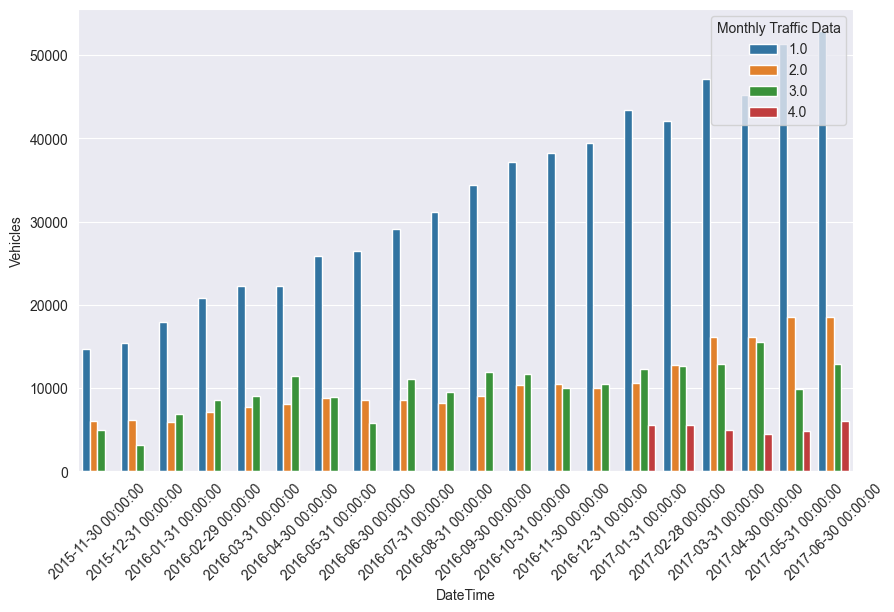

In [308]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df_time_targets, x="Date", y="Vehicles", hue="Junction")
plt.xlabel("DateTime")
plt.ylabel("Vehicles")
plt.xticks(rotation=45)
plt.legend(title="Monthly Traffic Data")
plt.show()

In [309]:
train = train.pivot(index='DateTime',columns='Junction',values='Vehicles')
train

Junction,1.0,2.0,3.0,4.0
DateTime,,,,
2015-11-01 00:00:00,15,6,9,NaN
2015-11-01 01:00:00,13,6,7,NaN
2015-11-01 02:00:00,10,5,5,NaN
2015-11-01 03:00:00,7,6,1,NaN
2015-11-01 04:00:00,9,7,2,NaN
...,...,...,...,...
2017-06-30 19:00:00,105,34,33,11
2017-06-30 20:00:00,96,35,31,30
2017-06-30 21:00:00,90,31,28,16


In [310]:
train= train.fillna(0) 
train

Junction,1.0,2.0,3.0,4.0
DateTime,,,,
2015-11-01 00:00:00,15,6,9,0
2015-11-01 01:00:00,13,6,7,0
2015-11-01 02:00:00,10,5,5,0
2015-11-01 03:00:00,7,6,1,0
2015-11-01 04:00:00,9,7,2,0
...,...,...,...,...
2017-06-30 19:00:00,105,34,33,11
2017-06-30 20:00:00,96,35,31,30
2017-06-30 21:00:00,90,31,28,16


Lag Features

In [311]:
def gen_lag_features(df, n_in=1, n_out=1, dropnan=True):  # n_in You must determine how many hours of delay feature you want to create.  # n_out You must determine how many hours of forecast you want to make.
    n_vars=df.shape[1]
    cols,names=list(),list()
    # input sequence (t-n,...t-1)
    for i in range(n_in,0,-1):
        cols.append(df.shift(i))
        names+=[('Junction %d (H-%d)'%(j+1,i)) for j in range(n_vars)]
    # forecast sequence (t,t+1...t+n)
    for i in range(0,n_out):
        cols.append(df.shift(-i))
        if i== 0:
            names+=[('Junction %d (H)' % (j+1)) for j in range(n_vars)]
        else:
            names+=[('Junction %d (H+%d)' % (j+1,i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols,axis=1)
    agg.columns=names
    # drop rows with Nan values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [312]:
train_lag = gen_lag_features(train, 1, 1, True)
train_lag

,Junction 1 (H-1),Junction 2 (H-1),Junction 3 (H-1),Junction 4 (H-1),Junction 1 (H),Junction 2 (H),Junction 3 (H),Junction 4 (H)
DateTime,,,,,,,,
2015-11-01 01:00:00,15.0,6.0,9.0,0.0,13,6,7,0
2015-11-01 02:00:00,13.0,6.0,7.0,0.0,10,5,5,0
2015-11-01 03:00:00,10.0,5.0,5.0,0.0,7,6,1,0
2015-11-01 04:00:00,7.0,6.0,1.0,0.0,9,7,2,0
2015-11-01 05:00:00,9.0,7.0,2.0,0.0,6,2,2,0
...,...,...,...,...,...,...,...,...
2017-06-30 19:00:00,95.0,34.0,38.0,17.0,105,34,33,11
2017-06-30 20:00:00,105.0,34.0,33.0,11.0,96,35,31,30
2017-06-30 21:00:00,96.0,35.0,31.0,30.0,90,31,28,16


In [313]:
scaler= MinMaxScaler(feature_range=(0,1))
train_lag[train_lag.columns] = scaler.fit_transform(train_lag[train_lag.columns])
train_lag

,Junction 1 (H-1),Junction 2 (H-1),Junction 3 (H-1),Junction 4 (H-1),Junction 1 (H),Junction 2 (H),Junction 3 (H),Junction 4 (H)
DateTime,,,,,,,,
2015-11-01 01:00:00,0.066225,0.106383,0.044693,0.000000,0.052980,0.106383,0.033520,0.000000
2015-11-01 02:00:00,0.052980,0.106383,0.033520,0.000000,0.033113,0.085106,0.022346,0.000000
2015-11-01 03:00:00,0.033113,0.085106,0.022346,0.000000,0.013245,0.106383,0.000000,0.000000
2015-11-01 04:00:00,0.013245,0.106383,0.000000,0.000000,0.026490,0.127660,0.005587,0.000000
2015-11-01 05:00:00,0.026490,0.127660,0.005587,0.000000,0.006623,0.021277,0.005587,0.000000
...,...,...,...,...,...,...,...,...
2017-06-30 19:00:00,0.596026,0.702128,0.206704,0.472222,0.662252,0.702128,0.178771,0.305556
2017-06-30 20:00:00,0.662252,0.702128,0.178771,0.305556,0.602649,0.723404,0.167598,0.833333
2017-06-30 21:00:00,0.602649,0.723404,0.167598,0.833333,0.562914,0.638298,0.150838,0.444444


In [314]:
X_train = train_lag[train_lag.index < '2017-03-01'].iloc[:,0:4]
X_train

,Junction 1 (H-1),Junction 2 (H-1),Junction 3 (H-1),Junction 4 (H-1)
DateTime,,,,
2015-11-01 01:00:00,0.066225,0.106383,0.044693,0.000000
2015-11-01 02:00:00,0.052980,0.106383,0.033520,0.000000
2015-11-01 03:00:00,0.033113,0.085106,0.022346,0.000000
2015-11-01 04:00:00,0.013245,0.106383,0.000000,0.000000
2015-11-01 05:00:00,0.026490,0.127660,0.005587,0.000000
...,...,...,...,...
2017-02-28 19:00:00,0.509934,0.553191,0.139665,0.194444
2017-02-28 20:00:00,0.549669,0.617021,0.139665,0.222222
2017-02-28 21:00:00,0.523179,0.617021,0.117318,0.361111


In [315]:
y_train = train_lag[train_lag.index < '2017-03-01'].iloc[:,4:]
y_train

,Junction 1 (H),Junction 2 (H),Junction 3 (H),Junction 4 (H)
DateTime,,,,
2015-11-01 01:00:00,0.052980,0.106383,0.033520,0.000000
2015-11-01 02:00:00,0.033113,0.085106,0.022346,0.000000
2015-11-01 03:00:00,0.013245,0.106383,0.000000,0.000000
2015-11-01 04:00:00,0.026490,0.127660,0.005587,0.000000
2015-11-01 05:00:00,0.006623,0.021277,0.005587,0.000000
...,...,...,...,...
2017-02-28 19:00:00,0.549669,0.617021,0.139665,0.222222
2017-02-28 20:00:00,0.523179,0.617021,0.117318,0.361111
2017-02-28 21:00:00,0.543046,0.553191,0.100559,0.194444


In [316]:
X_train.shape,y_train.shape

((11663, 4), (11663, 4))

In [317]:
X_train = np.expand_dims(X_train.values,axis=2)
print(X_train.shape)

y_train=y_train.values
print(y_train.shape)

(11663, 4, 1)
(11663, 4)


Model

In [318]:
def root_mean_squared_error(y_true,y_pred):
    return K.sqrt(K.mean(K.square(y_pred-y_true),axis=-1))

In [319]:
regressor = Sequential()

regressor.add(LSTM(units=50, activation='relu', kernel_initializer=he_normal(seed=0), input_shape=(None,1))) #Adding the input layer and the LSTM layer

regressor.add(Dense(units=4)) #output for 4 junctions

regressor.compile(optimizer='adam',loss=root_mean_squared_error) #compiling the RNN

Fitting the RNN to the Training set

In [320]:
regressor.fit(X_train,y_train,batch_size=128,epochs=100,verbose=1)

Epoch 1/100
92/92 [==============================] - 2s 8ms/step - loss: 0.0777
Epoch 2/100
92/92 [==============================] - 1s 8ms/step - loss: 0.0389
Epoch 3/100
92/92 [==============================] - 1s 8ms/step - loss: 0.0366
Epoch 4/100
92/92 [==============================] - 1s 8ms/step - loss: 0.0354
Epoch 5/100
92/92 [==============================] - 1s 7ms/step - loss: 0.0342
Epoch 6/100
92/92 [==============================] - 1s 8ms/step - loss: 0.0332
Epoch 7/100
92/92 [==============================] - 1s 7ms/step - loss: 0.0325
Epoch 8/100
92/92 [==============================] - 1s 8ms/step - loss: 0.0319
Epoch 9/100
92/92 [==============================] - 1s 7ms/step - loss: 0.0317
Epoch 10/100
92/92 [==============================] - 1s 7ms/step - loss: 0.0315
Epoch 11/100
92/92 [==============================] - 1s 7ms/step - loss: 0.0315
Epoch 12/100
92/92 [==============================] - 1s 8ms/step - loss: 0.0313
Epoch 13/100
92/92 [=================

Validation

In [321]:
X_valid = train_lag[train_lag.index >='2017-03-01'].iloc[:,0:4]
X_valid

,Junction 1 (H-1),Junction 2 (H-1),Junction 3 (H-1),Junction 4 (H-1)
DateTime,,,,
2017-03-01 00:00:00,0.503311,0.595745,0.134078,0.305556
2017-03-01 01:00:00,0.463576,0.638298,0.122905,0.222222
2017-03-01 02:00:00,0.344371,0.553191,0.072626,0.138889
2017-03-01 03:00:00,0.350993,0.489362,0.044693,0.138889
2017-03-01 04:00:00,0.298013,0.446809,0.027933,0.138889
...,...,...,...,...
2017-06-30 19:00:00,0.596026,0.702128,0.206704,0.472222
2017-06-30 20:00:00,0.662252,0.702128,0.178771,0.305556
2017-06-30 21:00:00,0.602649,0.723404,0.167598,0.833333


In [322]:
X_valid = np.expand_dims(X_valid.values,axis=2)
y_pred = regressor.predict(X_valid)

92/92 [==============================] - 1s 4ms/step


In [323]:
y_pred = scaler.inverse_transform(np.concatenate((X_valid.squeeze(),y_pred),axis=1))[:,4:]
y_pred

array([[77.30326396, 26.31444502, 22.51688705, 10.83282208],
       [71.27721569, 27.10445058, 19.9609073 ,  8.9530828 ],
       [54.74453062, 23.11119688, 13.04690926,  5.91448438],
       ...,
       [90.59138089, 31.45969236, 31.81926189, 22.0082159 ],
       [85.92918879, 28.55298835, 26.32590936, 13.80526972],
       [80.76302481, 26.84154028, 26.17253383, 16.65097868]])

In [324]:
y_valid = train[train.index>='2017-03-01']
y_valid

Junction,1.0,2.0,3.0,4.0
DateTime,,,,
2017-03-01 00:00:00,75,31,23,8
2017-03-01 01:00:00,57,27,14,5
2017-03-01 02:00:00,58,24,9,5
2017-03-01 03:00:00,50,22,6,5
2017-03-01 04:00:00,42,17,6,5
...,...,...,...,...
2017-06-30 19:00:00,105,34,33,11
2017-06-30 20:00:00,96,35,31,30
2017-06-30 21:00:00,90,31,28,16


In [325]:
root_mean_squared_error(y_valid, y_pred)

<tf.Tensor: shape=(2928,), dtype=float64, numpy=
array([2.97983764, 7.98450182, 2.67403291, ..., 3.57933193, 4.21845381,
       6.96123026])>

Visualizing Result fot the junctions

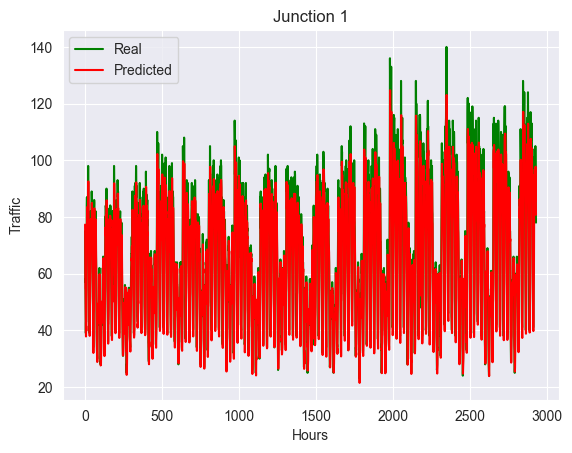

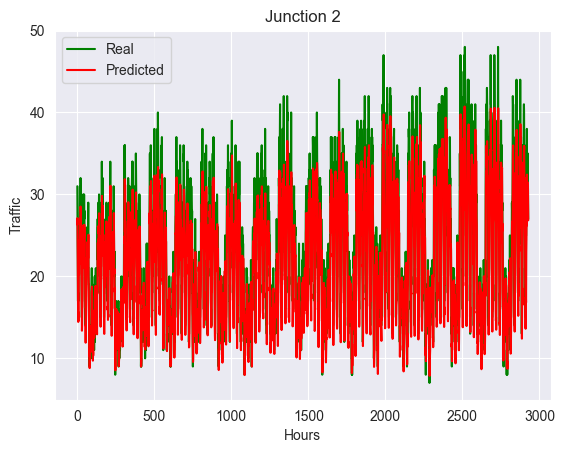

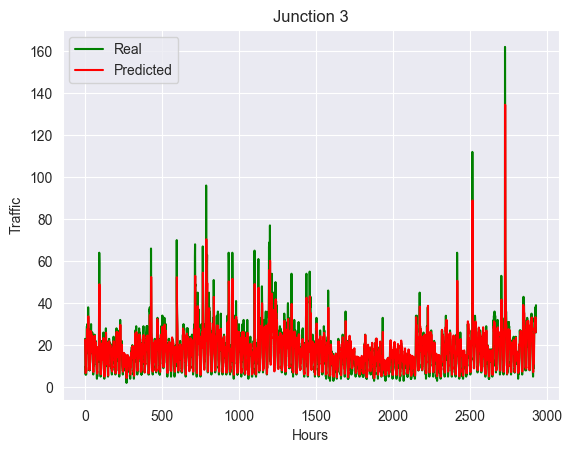

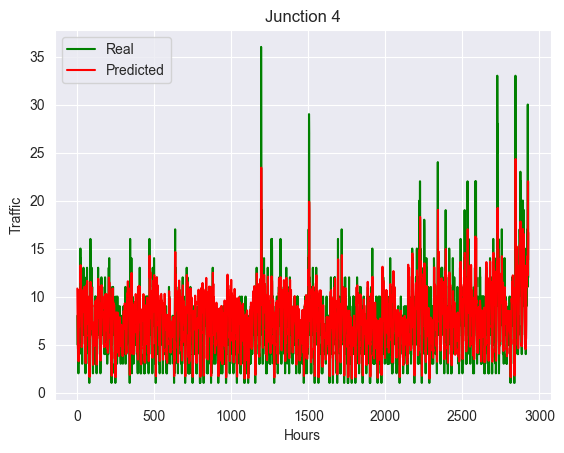

In [326]:
for junction in range(4):
    plt.figure
    plt.plot(y_valid.values[:,junction],color ='green',label='Real')
    plt.plot(y_pred[:,junction],color='red', label='Predicted')
    plt.title('Junction %i'%(junction+1))
    plt.xlabel('Hours')
    plt.ylabel('Traffic')
    plt.legend()
    plt.show()

In [327]:
def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true,y_pred))

In [328]:
rmse(y_valid, y_pred)

5.7965707801222806